In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

# Функции из 1-ого вебинара
import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
#from src.metrics import precision_at_k 

In [ ]:
#from implicit.evaluation import precision_at_k, mean_average_precision_at_k, AUC_at_k, ndcg_at_k

In [1]:
from implicit.evaluation import precision_at_k

In [2]:
data = pd.read_csv('retail_train.csv')

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)


test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [4]:
item_features.department.unique()

array(['GROCERY', 'MISC. TRANS.', 'PASTRY', 'DRUG GM', 'MEAT-PCKGD',
       'SEAFOOD-PCKGD', 'PRODUCE', 'NUTRITION', 'DELI', 'COSMETICS',
       'MEAT', 'FLORAL', 'TRAVEL & LEISUR', 'SEAFOOD', 'MISC SALES TRAN',
       'SALAD BAR', 'KIOSK-GAS', 'ELECT &PLUMBING', 'GRO BAKERY',
       'GM MERCH EXP', 'FROZEN GROCERY', 'COUP/STR & MFG', 'SPIRITS',
       'GARDEN CENTER', 'TOYS', 'CHARITABLE CONT', 'RESTAURANT', 'RX',
       'PROD-WHS SALES', 'MEAT-WHSE', 'DAIRY DELI', 'CHEF SHOPPE', 'HBC',
       'DELI/SNACK BAR', 'PORK', 'AUTOMOTIVE', 'VIDEO RENTAL', ' ',
       'CNTRL/STORE SUP', 'HOUSEWARES', 'POSTAL CENTER', 'PHOTO', 'VIDEO',
       'PHARMACY SUPPLY'], dtype=object)

In [3]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [4]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [5]:
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробоват ьдругие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

E:\anaconda\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
user_item_matrix.shape

(2499, 5001)

In [6]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [8]:
?AlternatingLeastSquares

In [7]:
csr_mat = csr_matrix(user_item_matrix).T.tocsr()

In [12]:
%%time

model = AlternatingLeastSquares(factors=100, #k
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)


Wall time: 6.65 s


In [13]:
[id_to_itemid[rec[0]] for rec in recs]

[1133018, 1106523, 999999, 5569230, 1082185]

In [13]:
def get_recommendations(user, model, N=5):
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)]
    return res

In [15]:
result

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107..."
3,7,"[840386, 889774, 898068, 909714, 929067, 95347..."
4,8,"[835098, 872137, 910439, 924610, 992977, 10412..."
...,...,...
2037,2496,[6534178]
2038,2497,"[1016709, 9835695, 1132298, 16809501, 845294, ..."
2039,2498,"[15716530, 834484, 901776, 914190, 958382, 972..."
2040,2499,"[867188, 877580, 902396, 914190, 951590, 95813..."


In [12]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    #print(bought_list)
    recommended_list = np.array(recommended_list)
    
    bought_list = bought_list  # Тут нет [:k] !!
    recommended_list = recommended_list[:k]
    
    flags = np.isin(bought_list, recommended_list)
    
    precision = flags.sum() / len(recommended_list)
    
    
    return precision

In [18]:
%%time
    
result['als'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
#result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()

Wall time: 55.6 s


In [22]:
result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()

0.16013712047012502

In [19]:
result.head(2)

,user_id,actual,als
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[5569374, 1033142, 1005186, 995242, 1105488]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1106523, 9337581, 826249, 5569327, 1133018]"


### 2. TF-IDF взвешивание

In [33]:
user_item_matrix = tfidf_weight(user_item_matrix.T).T  # Применяется к item-user матрице ! 

In [34]:
%%time

model = AlternatingLeastSquares(factors=100, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

result['als_tfidf'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

result.apply(lambda row: precision_at_k(row['als_tfidf'], row['actual']), axis=1).mean()


*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

 False False False False False False False False]
1
[False False False False False False False False False  True False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False  True False False False False False
 False False False False False False False False False False False False
 False False False False]
1
[False False False False False False False False False False  True False
 False False False False False False Fals

 False False False False False False False False False False]
1
[False False False False False False False  True False False False False
  True  True False False  True False False False False False False False
 False False False False False False False False False False False False
 False]
1
[ True False False False False False False False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False]
1
[False False False False False False False False False False False False
 False 

 False False False False False False False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False  True
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
1
[False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False  True False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False]
1
[False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False Fal

 False False False False False False False False  True False]
1
[False False False False False False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False Fals

 False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False  True False  True False False
 False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False  True False False
 False False False False False False False False False False False False
 False False False False False False]
1
[False False False False Fal

 False False False False False False False]
1
[False False False  True False False False False False False False False
 False False False False False False False False  True False False False]
1
[False False False False False False False False False False False False
 False False False]
1
[False False  True False False False False False False False  True False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
  True False False False False False]
1
[ True False False False False False False False False False False False
 False False False False False False False False False False False  True]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
  True False False False False False]
1
[False False False False False False  True False False False False False
 False False False False False False False 

 False False False False False False False False]
1
[False False False False False False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
1
[False False False False False False False False False False False False
 False False  True False False False False False False False False]
1
[False False False False False False False False]
1
[False False False False False False False False False False False False
 False False Fal

 False False False False False False]
1
[False False False False False False False False False False False False
 False False False False False  True False False False False False False
 False False False False False False False False]
1
[False False False  True False False False False False False False False]
1
[False False False False False False False  True False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False]
1
[False  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False]
1
[False False False]
1
[False False False False False  True False False False False False False
 False  True 

 False False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False Fals

 False False]
1
[ True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False  True False False False False
 False False False False False False False False False False False False
 False False False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fal

 False False False False False False False False False False False]
1
[False False False False False False False False False False False False
 False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False  True
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False  True False
 False False False False False False False False False False False False
 False False False False False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False  True False False False False
 False False False False False False False False Fals

 False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False]
1
[False False False False False False  True False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False  True False 

 False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
1
[False False False False False False False False False False False False]
1
[False False False False False False False False False False False False
 False False False  True False False False False False False  True False
 False]
1
[False  True False False False False False False False False]
1
[False  True  True False False False False False False False]
1
[False False False False False False False False False Fa

 False False False False False False False False False False False]
1
[False False False False False False False False False False False False
 False False  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False]
1
[False False False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False  True
 False False False False False False False Fals

 False False False]
1
[False False False False False False False False False False False False
 False False False  True False False False False False False False False
 False False  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False]
1
[False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False  True False False False False  True False False False
 False False False False False]
1
[False False  True False False False False False False  True False False
  True False False False False False False False False False False False
  True False False False False False False]
1
[False False Fa

 False]
1
[False False False False False False False False False False False False
 False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False]

 False False False False False False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False  True False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 Fal

 False False False False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False  True
 False False False False False False False False False]
1
[False False False False False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False  True False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False]
1
[False False False False False  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 Fal

 False]
1
[False  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False  True False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False Fals

 False False False False False False]
1
[False False False False False False False False False False False False
 False False False False False  True False  True False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
1
[False False False False False False False]
1
[False False False False False False False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False]
1
[False False Fa

 False False False False False False False False False]
1
[False False False False False False]
1
[False False False False False  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False]
1
[False False  True False False False False False False False False False
 False  True  True]
1
[ True False False False False False False False False False False False
 False False False False False]
1
[False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False]
1
[False F

 False False False False False False False False False False False False]
1
[False False False False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
1
[False False False]
1
[False False False False False False False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False]
1
[False False  True False False False False]
1
[False False False  True False False False False False False False False
 False False False False False False False False False False False False]
1
[False False False False False False False False False False False False


 False False False]
1
[False False False False  True False False False False False False False
 False False]
1
[False False  True False]
1
[False False False False False False False False False False False False
 False]
1
[False False False False False False]
1
[False False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False  True False False
 False False False False False False False False False False False False
 False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False 

 False]
1
[False False False False False False False False False False False False
 False False  True False False False False False]
1
[False False  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
1
[False False False False False False False False False False False False
 False False  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False  True False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
1
[False False False False False False False False False False False False
 False False False False False

 False False False False False]
1
[False False  True False False False False]
1
[False False False False False False False False False False False False
  True False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False Fal

 False False]
1
[False False False False False False False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False]
1
[False False False False False False False False False False False False
 False False False False  True False False False False False False False
 False False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False 

 False False]
1
[False False False False False False False False False False False False
 False]
1
[False  True False False False False False]
1
[False False False False False False False False False  True False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False  True False False False False False False False False
 False False  True False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False]
1
[False False False False False False False False False False False False
 False False False  True False False False False  True False False False
 False False Fa

 False False False False False False False False False False False]
1
[False False False False False False  True False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False]
1
[False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False]
1
[

 False False False False False False False False False]
1
[False False False False False False False  True False False False False
 False False]
1
[False False False False False False False False  True False]
1
[False False False False False False False False False  True False False
 False False False False False False False False False]
1
[False False False False False False False False False False False False
 False False False False False  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False 

 False False  True]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False  True False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False Fals

 False False False False False False False False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False  True]
1
[False False False False False False False False False False False False
 False False False False False False  True False False False False False
 False False False False False False False False False  True False False
 False False  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False  True False False False False False False False False False]
1
[False False False False False False False False False False False False
 False False]
1
[False False False False False False False False False False False False
 False False False False False False  True False False False False False
 False False]
1
[False False False False]
1
[False False

 False False False False]
1
[ True False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False  True
 False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False]
1
[False False False False False False False False False  True False False
 False False False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False


 False False False False False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False  True False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False F

 False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False  True False False False
 False False False False False False False False False False  True False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False]
1
[False False False False False False False False]
1
[False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False]
1
[False False False False False False False False False False False False
  True False False False False False]
1
[False False False Fals

 False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
  True False False False False False False False False False False False
 False False False False False False False]
1
[False False False False False  True]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 Fal

 False False False False False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
1
[False]
1
[False False False False False False False False False False False False
 False False False False False False  True False False False False False
 False False False False False False False False  True False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False Fal

 False False False False False False False False False False False  True]
1
[False False False False False False False False False False False False
 False False False]
1
[False False False  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False Fal

 False False False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False  True
 False False False False False False False False False False False False
 False False False False False False False False False False]
1
[False False False False False False False False False False False]
1
[False False False  True False False False False False False False False
 False False False False False  True False False False False False False
 False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False 

 False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False F

 False False False False False False False False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False  True False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False

 False False False False]
1
[False False False False  True False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False  True False False  True
 False]
1
[False False False False False False False False False False False False
 False False False False False False False False]
1
[False False False False False]
1
[False False False False False  True False False False False False False
 False False False False False False False False False False False False
 False False False False False  True False False False False False False
 False False False]
1
[False False False False False False False False False False False False
  True False False False  True False False False False False False False
 False False False False False False False False False False False False
 False]
1
[False False False False False False False False False False F

 False False False False False False False False False]
1
[False False False False False False False False False False False False
 False  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
  True False]
1
[False False  True False False False False False False False]
1
[False False False False False False False False False False False False
  True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False]
1
[False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False Fal

 False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False]
1
[False False False  True  True False False False False False False False
 False False False False False  True False False False False False False
 False False False False False False False False False False False False
 False False]
1
[False False False False False False False False False False False False
 False False False False False]
1
[False False False False False False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False Fal

 False False]
1
[False False False False False False  True False False False False False
 False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]
1
[False False False False False False False False False False False False
 False False False False False False False]
1
[False False False False False False False False False False False False
 False  True False False False False False False False False False False
 False False False False False]
1
[False  True False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False Fals

 False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False]
1
[False False False False False False False False False False False False
 False False False False  True False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
  True False False False False False False False False False F

 False False False False False False False False False False]
1
[False False False False False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False  True False False False False
 False False False False False False False False False False False False
 False False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False  True False False
 False False False False False False False False False False False False
 False]
1
[False  True False False False False False False False False False False
 False False False False 

 False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False]
1
[False False False False False False False False False]
1
[False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
1
[False False False False False False False False False False Fal

 False False False False False False False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False

 False False False False False False False False False False False]
1
[False False False False False False False False False False False  True
 False False False False False False False  True False False False False
 False False False False False False False]
1
[False False  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False F

 False False False False False False]
1
[False False False False False False False False  True False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False  True False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False]
1
[False False False False False False False False False False False False
 

 False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
  True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False]
1
[False False False False  True False False False False False False False
 False False False False False False False]
1
[False  True]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False 

 False False False False False False False False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False F

 False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False  True False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False]
1
[False False False False False False False False False False  True False
 False False False False False False False False False False False False
 False]
1
[False False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False

 False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False F

 False False]
1
[ True False False False False False False False False False False False
 False False False False False False False]
1
[False False False False False False False False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False]
1
[False]
1
[False False False False False False False False  True False  True False
 False False False False False  True False False False False False False
 False False False False False False False False False False False False
 False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False  True False
 False False False False False False False False False False False False
 False False False False False False False False False

 False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False]
1
[False False False False False False False False False False False False
 False  True False False False False  True False False False False False
 False False False False False False False False  True False False False
 False False False False False False False False False False False False
 False False False False False False False False Fals

 False False False False]
1
[False False False False False False False False False False False False
 False False False False False False]
1
[False False False False False False  True False False False False False
 False False False False False False False False False False False False
 False False False False False False False  True False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False  True False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False  True False
 False False False False False False False False False False False False
 False False Fal

 False False False False False False False False False False False]
1
[False False False False False False False False False False False False
 False False False False False  True False False False False False False
 False False False False False False False False False False False False
 False False False  True False False False False False False False False
 False]
1
[False False  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False]
1
[ True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False  True False False False False
 False False False False False False False False False Fals

 False False False False False False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False]
1
[False False False False False False False False False False False  True
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False F

 False False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False]
1
[False False False False False False False False False False False False
 False False False False]
1
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False  True False False False False False False False False
 False False False False False False False False False False False False
 False False False]
1
[False False False False False False False False 

In [65]:
result.apply(lambda row: precision_at_k(row['als_tfidf'], row['actual']), axis=1).mean()

0.15138121546961125

### Теоретическая часть
1. Вспомним прошлый вебинар, мы рассматривали User-User рекомендации и Item-Item рекомендации. Чем они отличаются и чем они похожи? Если есть функция item_item_rec(interaction_matrix). Можно ли использовать эту функцию для user_user_rec?
В чем принципиальные отличия item-item рекомендаций от ALS?
3. Приведите 3 примера весов (те, которых не было на вебинаре: сумма покупок, количество покупок - неинтересно) user-item матрицы для задачи рекомендаций товаров
3. Какие ограничения есть у ALS? (Тип информации, линейность/нелинейность факторов и т д)
4. Мы рассматривали bm_25_weight. Опишите, как он работает. Как сделать рекомендации только на основе bm_25? (Можно и нужно пользоваться любыми источниками, приложите на них ссылки). Какие еще способы перевзвешивания user-item матрицы Вы знаете / можете предложить (ещё 2-3 способа)?

#### 1
User-User и Item-Item работают по абсолютно одинаковому алогритму, только на вход подаются в первом случае u-u матрица, а во втором i-i матрица. Преимущетво i-i матрицы в том, что зачастую количество айтемов гораздо меньше, по сравнению с количеством пользователей , что позволяет значительно сократить сложность расчетов. 

 при ALS мы формируем две вспомогательных матрицы, из которых потом получаем новую матрицу, отличную (хоть и немного) от первоначальной. В item-item рекомендациях работа происходит с изначальнйо матрицей весов, без видоизменений.

#### 2 

Я возможно не понял немного вопрос, но мы ведь использовали нестандартные веса: тф-идф, бм25, в дз я использовал веса из научной статьи. Больше ничего не приходит на ум.

#### 3

 ALS рабоатет только с имплисит данными, а item-item , user-user - с любыми типами оценок. 

#### 4
Про бм25 читал тут (http://webline.blog/algoritm-okapi-bm25-modifikacziya-formuly-tf-idf-ranzhirovaniya-dokumentov/), очень понравилась статья.
По поводу алгоритма: как и тф-идф -это функция для расчета релевантнсоти документов. Происходит оценка схожести запроса и содержания документа на основании частотности слов в документе и во всем корпусе. Главное отличие от тф-идф в том, что в нем применяются коэффициенты, которые сглаживают рост оценки релевантности при увеличении количества вхождений слова из запроса  в документ (бм25 растет ассимптотически, тф-идф стремится к бесконечности)
К примеру, с помощью бм25 (как и с помощью тф идф) можно делать Content-based рекомендации для книг. Можно собрать всю информацию о предыдущих покупках пользователя и с помощью бм25 найти наиболее похожие на эти покупки книги (по их описанию).

#### Подбор матрицы  𝑐𝑢𝑖 
Попробуйте различные варианты матрицы весов (3+ вариантов). Обучите алгоритм для различных  𝐶 . В качестве результата приведите таблицу: матрица весов - результат на train и validation. Сделате качественные выводы.

Насколько я понял, речь идет про confidence. Опять же как я понял, то задавать его как параметр нельзя, только использовать уже примененные к матрице веса.
Я решил применить формулу веса из оригинальной статьи http://yifanhu.net/PUB/cf.pdf

Сui = 1 + αRui


В статье указано, что оптимальное число 40, я начну с 15, потом посмотрю на 40.

Во всех расчетах я не буду использолвать свободную единицу в формуле, потому что с ней код не выполнялся из-за проблемы с памятью на моей машине. Не тянул вычисления, так как вместо 0 появились 1 и матрица перестала быть разреженной. 

In [24]:
alpha_val = 15
user_item_matrix = (user_item_matrix * alpha_val).astype('double')

In [26]:
model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

result['als_15a'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

result.apply(lambda row: precision_at_k(row['als_15a'], row['actual']), axis=1).mean()

0.16709108716943935

Есть хорошее улучшение, по сравнению с базовыми и взвешенными алгоритмами.

In [12]:
alpha_val = 40
user_item_matrix = (user_item_matrix * alpha_val).astype('double')

In [13]:
model = AlternatingLeastSquares(factors=100, #k
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

In [14]:
model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

result['als_40a'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

result.apply(lambda row: precision_at_k(row['als_40a'], row['actual']), axis=1).mean()

0.15739471106757857

Резульат оказался хуже, чем при альфа=15, но лучше, чем у базовых алгоритмов.

В третьем варианте еще одна формула С из статьи. Правда я не понял, что такое q, поэтому без нее счтитал.

Сui = 1 + α log(1 + Rui/ǫ).

In [8]:
alpha_val = 20

In [9]:
user_item_matrix = (np.log(1+user_item_matrix) * alpha_val).astype('double')

In [ ]:
user_item_matrix

In [10]:
model = AlternatingLeastSquares(factors=100, #k
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

In [14]:
model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

result['als_20a'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))



In [16]:
result.apply(lambda row: precision_at_k(row['als_20a'], row['actual']), axis=1).mean()

0.17130264446620716

Последний вариант оказался самым успешным, жаль, что не получилось проверить все вычисления с единицей в формуле.

### Оптимизация гипперпараметров
Для лучшей матрицы весов из первого задания подберите оптимальные  𝜆  и n_factors. Подбор можно делать вручную (цикл в цикле, аналог sklearn.GridSearch, или случайно - sklearn.GridSearch). Или Вы можете воспользоваться библиотеками для автоматического подбора гипперпараметров (любые на Ваш вкус). В качестве результата постройте графики


In [17]:
n_factors=[10,50,100,200]
alpha=[0.001,0.01,0.1]

In [34]:
answer=pd.DataFrame(index=np.arange(15),columns=['alpha','n_factors','result', 'time'])

In [37]:
q=0
for a in alpha:
    for n in n_factors:
        model = AlternatingLeastSquares(factors=n, #k
                                regularization=a,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)
        model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)
        result['buffer'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
        
        answer.iloc[q,0]=a
        answer.iloc[q,1]=n
        answer.iloc[q,2]=result.apply(lambda row: precision_at_k(row['buffer'], row['actual']), axis=1).mean()
        
        q+=1
        

In [38]:
answer

,alpha,n_factors,result,time
0,0.001,10,0.182958,NaN
1,0.001,50,0.182566,NaN
2,0.001,100,0.17238,NaN
3,0.001,200,0.169246,NaN
4,0.01,10,0.183154,NaN
5,0.01,50,0.180901,NaN
6,0.01,100,0.174535,NaN
7,0.01,200,0.167875,NaN
8,0.1,10,0.182272,NaN
9,0.1,50,0.18237,NaN


Вычисления происходили долго, поэтому ограничился небольшой сеткой параметров.

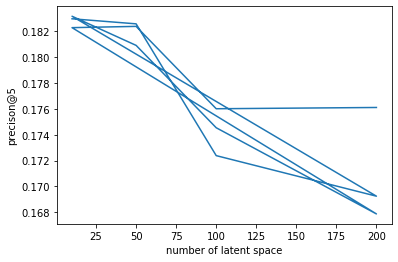

In [39]:
plt.plot(answer['n_factors'], answer['result'])
plt.ylabel('precison@5')
plt.xlabel('number of latent space')
plt.show()

Во всех проведенных испытаниях оказалось, что небольшое количество скрытых параметров выигрывало у большого,  увеличение количества скрытых параметров значительно ухудшало результаты предсказаний.
Регуляризация на данном примере не отработала, она почти не влияла на результат. Что для меня оказалось странным, в других алгоритмах скорость обучения очень сильно сказывается на результатах модели. 

